In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/aqt/'))

In [6]:
import numpy as np

import qiskit
provider = qiskit.IBMQ.load_account()

from qiskit_aqt_provider import AQTProvider
aqt = AQTProvider('6f47670f3e5c414da0cdcab1c048eb97')
simulator_backend =  aqt.backends.aqt_qasm_simulator_noise_1

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *
from matplotlib import pyplot as plt
%matplotlib inline

ibmqfactory.load_account:WARNING:2021-08-22 15:57:45,921: Credentials are already in use. The existing account in the session will be replaced.


In [7]:
%load_ext autoreload
%autoreload 2

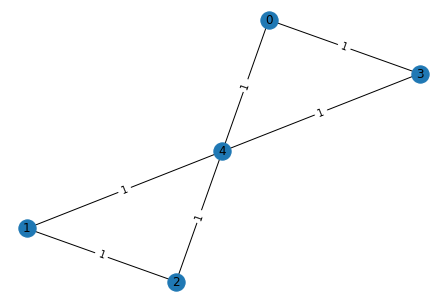

In [8]:
# ---- Define graph and MaxCut ----
graph = generate_butterfly_graph(with_weights=False)
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

In [9]:
# ---- Define step size and gamma, beta values ----
step_size = 0.1
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)

In [10]:
gammas, betas = np.meshgrid(a_gamma, b_beta)

In [11]:
def run_qaoa(gamma, beta):
    qaoa = QAOA(optimizer=COBYLA(maxiter=0),
                quantum_instance=simulator_backend,
                reps=1,
                initial_point=[gamma, beta])
    algorithm = MinimumEigenOptimizer(qaoa)
    result = algorithm.solve(max_cut_qubo)
    optimal_parameters = qaoa.optimal_params
    mean, distribution = max_cut.analyse(result)

    return mean

In [12]:
# ---- execute for all values QAOA and get result matrix  ----
landscape = np.zeros(gammas.shape)
for i in range(0, len(landscape)):
    for j in range(0, len(landscape)):
        landscape[i,j] = run_qaoa(gammas[i][j], betas[i][j])
    print(f"Row {i} done")

Row 0 done
Row 1 done
Row 2 done
Row 3 done


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


KeyboardInterrupt: 

In [ ]:
print(landscape)
plt.matshow(landscape)
plt.show()

In [ ]:
# Mean of landscape
np.mean(landscape)

In [ ]:
# Minimium 
np.min(landscape)

In [ ]:
# Display Coordinates of Minimum 
np.unravel_index(np.argmin(landscape), landscape.shape)

In [ ]:
# Gamma and beta value of Minimium
gamma, beta = np.unravel_index(np.argmin(landscape), landscape.shape)
opt_gamma = gamma * step_size
opt_beta = beta * step_size
print(f"Opt.Gamma: {opt_gamma}, Opt.Beta: {opt_beta}")

In [ ]:
# Save result matrix 
with open('landscape_noise_simulator_butterfly_no_weights_results.npy', 'wb') as f:
    np.save(f, landscape)

In [ ]:
import plotly.graph_objects as go

In [ ]:
# Plot landscape in 3D 
a_gamma = np.arange(0, np.pi, step_size)
b_beta = np.arange(0, np.pi, step_size)
fig = go.Figure(data=go.Surface(z=landscape, x=a_gamma, y=b_beta))

fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor='limegreen', project_z=True))


fig.update_layout(title="QAOA MaxCut", scene=dict(
    xaxis_title="gamma",
    yaxis_title="beta",
    zaxis_title="mean"
))

In [ ]:
# Plot Heatmap 
fig = go.Figure(data=go.Heatmap(z=landscape, x=b_beta, y=a_gamma, type = 'heatmap', colorscale = 'viridis'))

# Update Layout
fig.update_layout(title="QAOA MaxCut", width=700, height=700, xaxis_title="beta", yaxis_title="gamma")

# Display Global Minimium 
fig.add_trace(
    go.Scatter(mode="markers", x=[opt_beta], y=[opt_gamma], marker_symbol=[204], text = [landscape[gamma,beta]],
                   marker_color="red",  hovertemplate="x: %{x}<br>y: %{y}<br> z: %{text:.2f}<extra></extra>", 
                   marker_line_width=1, marker_size=16))


In [ ]:
# Display Optimizer Results

# Display path 
#fig.add_trace(
#    go.Scatter(mode="lines", x=gammas, y=betas, marker_symbol=[200],
#                   marker_color="white", marker_line_width=1, marker_size=8)
#)

# Display start point
#fig.add_trace(
#    go.Scatter(mode="markers", x=[gammas[0]], y=[betas[0]], marker_symbol=[204],
#                   marker_color="gray", 
#                   marker_line_width=1, marker_size=16))

# Display end point
#fig.add_trace(
#    go.Scatter(mode="markers", x=[gammas[-1]], y=[betas[-1]], marker_symbol=[204],
#                   marker_color="green", 
#                   marker_line_width=1, marker_size=16))



In [ ]:
# Plot Optimizer History
#fig = go.Figure(data=go.Scatter(x=counts, y=values))
#fig.update_layout(xaxis_title="Evaluation Counts", yaxis_title="Evaluated Mean", title="Optimizer")
#fig.show()